In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
plt.rcParams["figure.figsize"] = (12,6)
import seaborn as sns

In [2]:
import random
import scipy
from scipy.stats import ttest_1samp
import statsmodels.api as sm
import scipy.stats as stats
from prettytable import PrettyTable

In [3]:
%%time
df1 = pd.read_csv('Quote-Equity-NETWORK18-EQ-26-12-2019-to-26-12-2021.csv')
df2 = pd.read_csv('Quote-Equity-TV18BRDCST-EQ-26-12-2019-to-26-12-2021.csv')

CPU times: user 12.1 ms, sys: 4.67 ms, total: 16.8 ms
Wall time: 21.3 ms


In [4]:
#lets see how columns look like
df1.columns

Index(['Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ', 'PREV. CLOSE ', 'ltp ',
       'close ', 'vwap ', '52W H ', '52W L ', 'VOLUME ', 'VALUE ',
       'No of trades '],
      dtype='object')

In [5]:
#lets carve out the columns which we need
df1 = df1[['Date ', 'OPEN ', 'close ']]
df2 = df2[['Date ', 'OPEN ', 'close ']]
df1.columns = ['date', 'open', 'close']
df2.columns = ['date', 'open', 'close']

#convert date to datetime format
df1.date = pd.to_datetime(df1['date'], infer_datetime_format=True)
df2.date = pd.to_datetime(df2['date'], infer_datetime_format=True)

In [6]:
df1

,date,open,close
0,2021-12-24,88.90,91.50
1,2021-12-23,89.20,87.25
2,2021-12-22,89.00,88.40
3,2021-12-21,85.25,87.60
4,2021-12-20,90.80,83.45
...,...,...,...
445,2020-03-11,22.65,22.65
446,2020-03-09,23.50,23.45
447,2020-03-06,25.00,24.65
448,2020-03-05,26.60,25.75


In [7]:
#since we want the data in increasing date order
df1 = df1.sort_index(ascending=False)
df2 = df2.sort_index(ascending=False)

In [8]:
df1

,date,open,close
449,2020-03-04,26.95,25.70
448,2020-03-05,26.60,25.75
447,2020-03-06,25.00,24.65
446,2020-03-09,23.50,23.45
445,2020-03-11,22.65,22.65
...,...,...,...
4,2021-12-20,90.80,83.45
3,2021-12-21,85.25,87.60
2,2021-12-22,89.00,88.40
1,2021-12-23,89.20,87.25


In [9]:
#creating a new feature containing the daily returns(r) for both the datasets

df1['r'] = np.log(df1['close']/df1['close'].shift(1))*100

df2['r'] = np.log(df2['close']/df2['close'].shift(1))*100

In [10]:
df1

,date,open,close,r
449,2020-03-04,26.95,25.70,NaN
448,2020-03-05,26.60,25.75,0.194364
447,2020-03-06,25.00,24.65,-4.365773
446,2020-03-09,23.50,23.45,-4.990641
445,2020-03-11,22.65,22.65,-3.471064
...,...,...,...,...
4,2021-12-20,90.80,83.45,-8.441164
3,2021-12-21,85.25,87.60,4.853335
2,2021-12-22,89.00,88.40,0.909097
1,2021-12-23,89.20,87.25,-1.309441


In [11]:
df2

,date,open,close,r
498,2019-12-26,21.20,21.10,NaN
497,2019-12-27,21.20,21.20,0.472814
496,2019-12-30,21.30,21.15,-0.236128
495,2019-12-31,21.25,21.15,0.000000
494,2020-01-01,21.25,21.25,0.471699
...,...,...,...,...
4,2021-12-20,45.00,43.75,-4.031901
3,2021-12-21,44.50,44.05,0.683374
2,2021-12-22,44.90,45.30,2.798168
1,2021-12-23,45.65,44.65,-1.445273


In [12]:
#merge both datasets with suffixes of their repecpected names
df = pd.merge(df1, df2, on = ['date'], suffixes= ['_net', '_tv'])

In [13]:
df

,date,open_net,close_net,r_net,open_tv,close_tv,r_tv
0,2020-03-04,26.95,25.70,NaN,22.60,22.00,-2.247286
1,2020-03-05,26.60,25.75,0.194364,22.05,22.40,1.801851
2,2020-03-06,25.00,24.65,-4.365773,21.10,20.85,-7.170701
3,2020-03-09,23.50,23.45,-4.990641,20.05,18.80,-10.349708
4,2020-03-11,22.65,22.65,-3.471064,18.85,19.45,3.399020
...,...,...,...,...,...,...,...
445,2021-12-20,90.80,83.45,-8.441164,45.00,43.75,-4.031901
446,2021-12-21,85.25,87.60,4.853335,44.50,44.05,0.683374
447,2021-12-22,89.00,88.40,0.909097,44.90,45.30,2.798168
448,2021-12-23,89.20,87.25,-1.309441,45.65,44.65,-1.445273


In [14]:
#So we can use use 3 types of measures for pairs trading

#differential is just the difference of 2 stocks daily close prices
df['differential'] = df.close_net - df.close_tv

#ratio is the ratio of one stock w.r.t other
df['ratio'] = df.close_net/df.close_tv

#spread is the difference in absolute daily return of one stock w.r.t other stock
df['spread'] = (df.open_net - df.close_net) - (df.open_tv - df.close_tv)

In [15]:
#let's drop the Nan's that got created because of return calculation
df.dropna(axis=0, inplace = True)

In [16]:
#everything looks cool
df

,date,open_net,close_net,r_net,open_tv,close_tv,r_tv,differential,ratio,spread
1,2020-03-05,26.60,25.75,0.194364,22.05,22.40,1.801851,3.35,1.149554,1.20
2,2020-03-06,25.00,24.65,-4.365773,21.10,20.85,-7.170701,3.80,1.182254,0.10
3,2020-03-09,23.50,23.45,-4.990641,20.05,18.80,-10.349708,4.65,1.247340,-1.20
4,2020-03-11,22.65,22.65,-3.471064,18.85,19.45,3.399020,3.20,1.164524,0.60
5,2020-03-12,21.55,21.55,-4.978404,17.75,17.15,-12.584890,4.40,1.256560,-0.60
...,...,...,...,...,...,...,...,...,...,...
445,2021-12-20,90.80,83.45,-8.441164,45.00,43.75,-4.031901,39.70,1.907429,6.10
446,2021-12-21,85.25,87.60,4.853335,44.50,44.05,0.683374,43.55,1.988649,-2.80
447,2021-12-22,89.00,88.40,0.909097,44.90,45.30,2.798168,43.10,1.951435,1.00
448,2021-12-23,89.20,87.25,-1.309441,45.65,44.65,-1.445273,42.60,1.954087,0.95


In [17]:
table1 = PrettyTable()
table1.title = 'Summary Table-1 of Parameters'
table1.field_names = ['Parameter', 'Value']
table1.add_row(['Correlation of close prices of tv18 and network18', df.close_net.corr(df.close_tv)])
table1.add_row(['Correlation of returns of tv18 and network18', df.r_net.corr(df.r_tv)])
table1.add_row(['Correlation of daily absolute change in tv18 and network18', (df.open_net - df.close_net).corr((df.open_tv - df.close_tv))])
print(table1)

+---------------------------------------------------------------------------------+
|                          Summary Table-1 of Parameters                          |
+------------------------------------------------------------+--------------------+
|                         Parameter                          |       Value        |
+------------------------------------------------------------+--------------------+
|     Correlation of close prices of tv18 and network18      | 0.854471308923386  |
|        Correlation of returns of tv18 and network18        | 0.7498296381682455 |
| Correlation of daily absolute change in tv18 and network18 | 0.7016484096947135 |
+------------------------------------------------------------+--------------------+


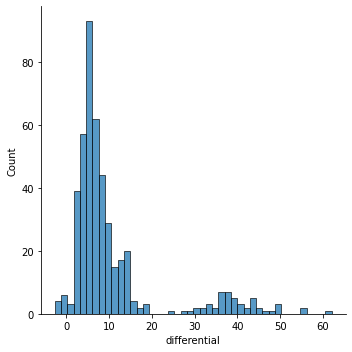

In [18]:
#checking the distribution of our differentials..doesn't look normal
sns.displot(df.differential)

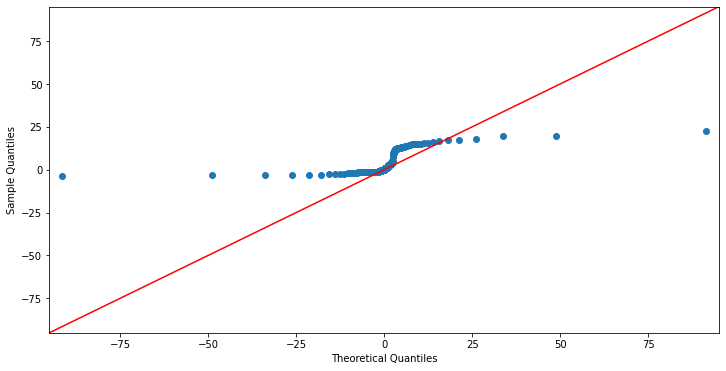

In [19]:
#confirming if differential is really not normal(using quantile quantile plot)
plot1 = sm.qqplot(df.differential,line='45',fit=True, dist=stats.t)

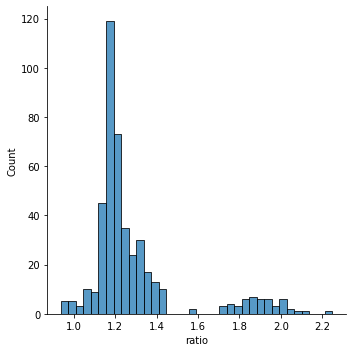

In [20]:
#checking the distribution of ratio, doesn't look normal
sns.displot(df.ratio)

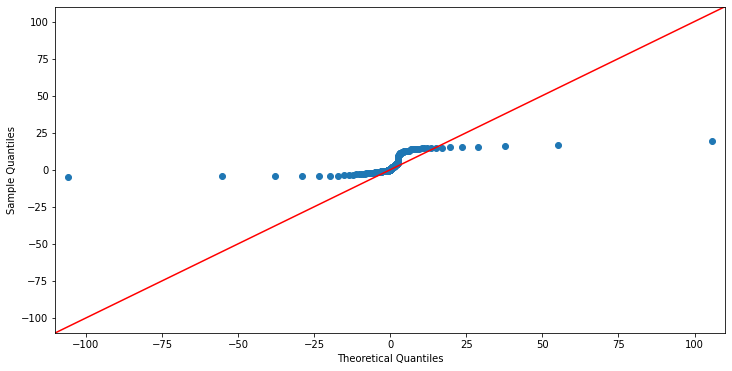

In [21]:
#checking if it's really normal or not using quantile quantile plot
plot2 = sm.qqplot(df.ratio,line='45',fit=True, dist=stats.t)

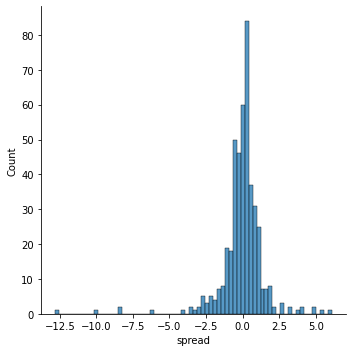

In [22]:
#checking for spreads if it's distribution is normal, looks slightly like, but we need to verify
sns.displot(df.spread)

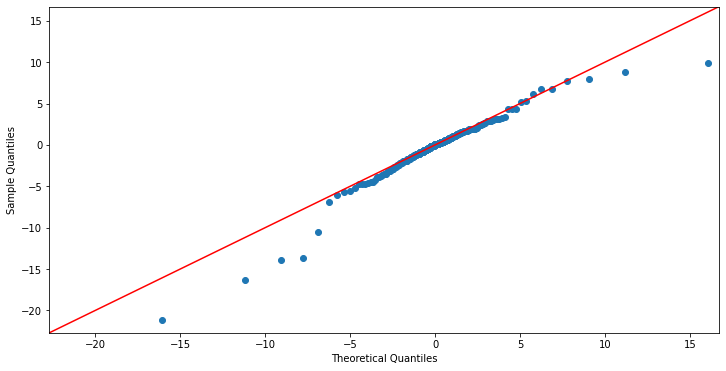

In [23]:
#checked for normal:not exaclty normal
#better fit with quantiles of t distributiion, but still not exactly
plot3 = sm.qqplot(df.spread,line='45',fit=True, dist=stats.t)

In [24]:
table2 = PrettyTable()
table2.title = 'Summary Table-2 of Parameters'
table2.field_names = ['Parameter', 'Value']

table2.add_row(['Mean Of Differential', df.differential.mean()])               
table2.add_row(['Median Of Differential', df.differential.median()])
table2.add_row(['Standarad Deviation Of Differential', df.differential.std()])
table2.add_row(['Skewness Of Differential', df.differential.skew()])
table2.add_row(['Kurtosis Of Differential', df.differential.kurt()])
#table2.hrules() 

table2.add_row(['Mean Of Ratio', df.ratio.median()])               
table2.add_row(['Median Of Ratio', df.ratio.median()])
table2.add_row(['Standarad Deviation Of Ratio', df.ratio.std()])
table2.add_row(['Skewness Of Ratio', df.ratio.skew()])
table2.add_row(['Kurtosis Of Ratio', df.ratio.kurt()])

table2.add_row(['Mean Of Spread', df.spread.median()])               
table2.add_row(['Median Of Spread', df.spread.median()])
table2.add_row(['Standarad Deviation Of Spread', df.spread.std()])
table2.add_row(['Skewness Of Spread', df.spread.skew()])
table2.add_row(['Kurtosis Of Spread', df.spread.kurt()])

print(table2)

+-----------------------------------------------------------+
|               Summary Table-2 of Parameters               |
+-------------------------------------+---------------------+
|              Parameter              |        Value        |
+-------------------------------------+---------------------+
|         Mean Of Differential        |  10.498886414253898 |
|        Median Of Differential       |  6.600000000000001  |
| Standarad Deviation Of Differential |  11.214912987211724 |
|       Skewness Of Differential      |  2.256820744356811  |
|       Kurtosis Of Differential      |  4.4280555195545155 |
|            Mean Of Ratio            |  1.2091503267973855 |
|           Median Of Ratio           |  1.2091503267973855 |
|     Standarad Deviation Of Ratio    | 0.23464068327980267 |
|          Skewness Of Ratio          |  2.010560802388713  |
|          Kurtosis Of Ratio          |  3.365253158938828  |
|            Mean Of Spread           | 0.09999999999999432 |
|       

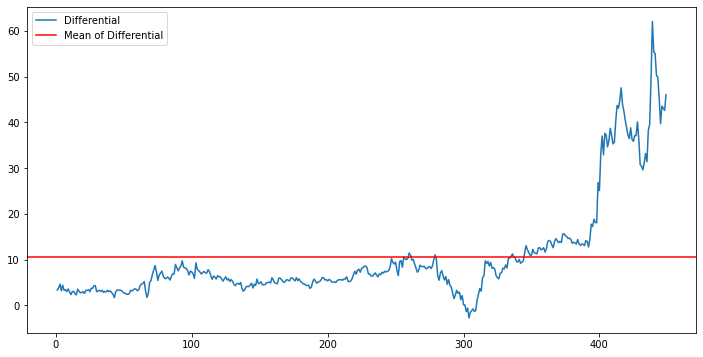

In [25]:
#check how the differntial has varied over the time
#we can expect the differential to remain in range because for a stock having higher absolute price, if the change 
#is x% then the absolute price increase will be more than for a x% increase in lower priced stock and over time
#differtial would widen up a bit
plt.plot(df.differential, label='Differential')
plt.axhline(y = df.differential.mean(), color='r', linestyle='-', label='Mean of Differential')
plt.legend()

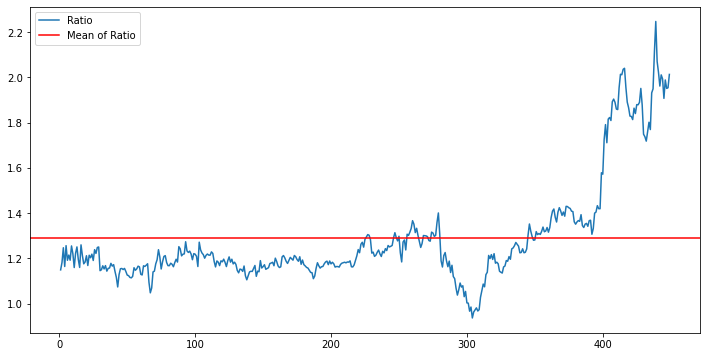

In [26]:
#now for ratio, if the initial ratio is greater than 1, then with both stocks increasing by same absolute amount 
#will make the ratio to converge towards 1...but since the absolute value increase for x% increase will be much 
#lower for the stock lower price than for higher ..this ratio will also tend to increase over time if both stocks 
#are supposed to have similar percentage returns
plt.plot(df.ratio, label='Ratio')
plt.axhline(y = df.ratio.mean(), color='r', linestyle='-', label='Mean of Ratio')
plt.legend()

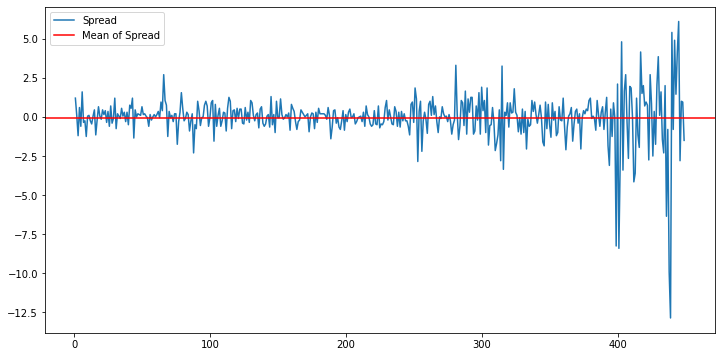

In [27]:
#this looks good as it is centered around 0
plt.plot(df.spread, label='Spread')
plt.axhline(y = df.spread.mean(), color='r', linestyle='-', label='Mean of Spread')
plt.legend()

In [28]:
#percentiles
np.percentile(df.ratio, [.3, 99.7])

array([0.96466434, 2.0978054 ])

In [29]:
#kind = ‘weak’: This kind corresponds to the definition of a cumulative distribution function. 
#A percentileofscore of 80% means that 80% of values are less than or equal to the provided score.

#kind = ‘strict’: Similar to “weak”, except that only values that are strictly less than the given score 
#are counted.
#kind = ‘mean’: The average of the “weak” and “strict” scores

#In this case all 3 are same

print(stats.percentileofscore(df.ratio, 1.8917901695829962, kind='weak'))
print(stats.percentileofscore(df.ratio, 1.8917901695829962, kind='strict'))
print(stats.percentileofscore(df.ratio, 1.8917901695829962, kind='mean'))


94.87750556792874
94.87750556792874
94.87750556792874


In [30]:
#now to trade we take long position on the pair(long the numerator stock and short the denominator stock) if the 
#above calculated measures is in between 2nd and 3rd stdv or neer 3 stdv on the left side of distribution(0.3%)

#Pain points: if takes long time to return to mean then there's problem(pay a lot of fee due to short position)

ratio_lst = [] 
spread_lst = []
for val in df.ratio:
    ratio_lst.append(stats.percentileofscore(df.ratio, val, kind='mean'))
    spread_lst.append(stats.percentileofscore(df.ratio, val, kind='mean'))

#stored percentile of evey time series value of ratio and spread, 
#they are supposed to return back to mean
df['density_ratio'] = ratio_lst      
df['density_spread'] = spread_lst


In [31]:
df

,date,open_net,close_net,r_net,open_tv,close_tv,r_tv,differential,ratio,spread,density_ratio,density_spread
1,2020-03-05,26.60,25.75,0.194364,22.05,22.40,1.801851,3.35,1.149554,1.20,15.033408,15.033408
2,2020-03-06,25.00,24.65,-4.365773,21.10,20.85,-7.170701,3.80,1.182254,0.10,35.746102,35.746102
3,2020-03-09,23.50,23.45,-4.990641,20.05,18.80,-10.349708,4.65,1.247340,-1.20,63.808463,63.808463
4,2020-03-11,22.65,22.65,-3.471064,18.85,19.45,3.399020,3.20,1.164524,0.60,24.610245,24.610245
5,2020-03-12,21.55,21.55,-4.978404,17.75,17.15,-12.584890,4.40,1.256560,-0.60,66.481069,66.481069
...,...,...,...,...,...,...,...,...,...,...,...,...
445,2021-12-20,90.80,83.45,-8.441164,45.00,43.75,-4.031901,39.70,1.907429,6.10,95.434298,95.434298
446,2021-12-21,85.25,87.60,4.853335,44.50,44.05,0.683374,43.55,1.988649,-2.80,97.438753,97.438753
447,2021-12-22,89.00,88.40,0.909097,44.90,45.30,2.798168,43.10,1.951435,1.00,96.325167,96.325167
448,2021-12-23,89.20,87.25,-1.309441,45.65,44.65,-1.445273,42.60,1.954087,0.95,96.770601,96.770601


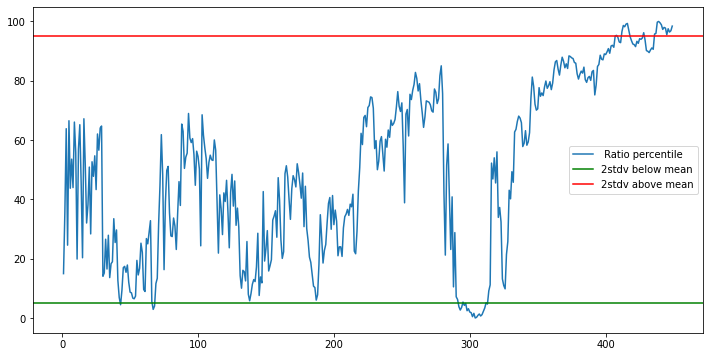

In [32]:
plt.plot(df.density_ratio, label = ' Ratio percentile')
plt.axhline(y = 5, color='g', linestyle='-', label='2stdv below mean')
plt.axhline(y = 95, color='r', linestyle='-', label='2stdv above mean')
plt.legend()


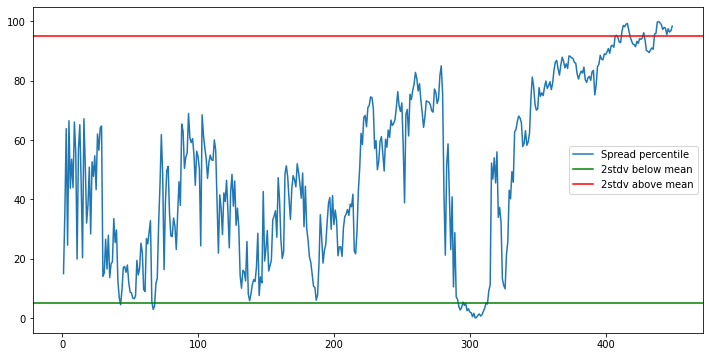

In [33]:
plt.plot(df.density_spread, label = 'Spread percentile')
plt.axhline(y = 5, color='g', linestyle='-', label='2stdv below mean')
plt.axhline(y = 95, color='r', linestyle='-', label='2stdv above mean')
plt.legend()

In [35]:
#Stationarity of the ratios
#here p value is worst, we fail to reject the null that series is non stationary
from statsmodels.tsa.stattools import adfuller
result1 = adfuller(df.ratio)
print('ADF Statistic:',result1[0])
print('p-value:', result1[1])
for key, value in result1[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.05603534076922043
p-value: 0.9629280250240638
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [37]:
#Stationarity of the differentials
#here p value is worst, we fail to reject the null that series is non stationary
from statsmodels.tsa.stattools import adfuller
result1 = adfuller(df.differential)
print('ADF Statistic:',result1[0])
print('p-value:', result1[1])
for key, value in result1[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.2801810206123452
p-value: 0.99649562967447
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [36]:
#Stationarity of the spread
#here p value is very less, we reject the null that series is non stationary
from statsmodels.tsa.stattools import adfuller
result1 = adfuller(df.spread)
print('ADF Statistic:',result1[0])
print('p-value:', result1[1])
for key, value in result1[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.89680425835057
p-value: 2.8387975362380766e-07
	1%: -3.446
	5%: -2.868
	10%: -2.570


In [38]:
### Method----2: Based on error of linear regression on both stocks closing prices

<AxesSubplot:xlabel='close_tv', ylabel='close_net'>

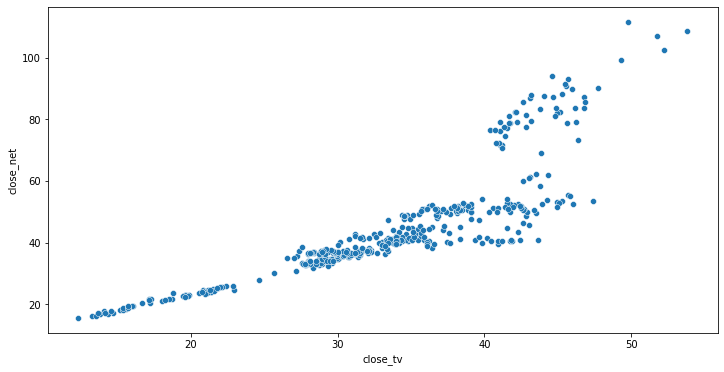

In [40]:
sns.scatterplot(x = df.close_tv, y = df.close_net)

<AxesSubplot:xlabel='close_tv', ylabel='close_net'>

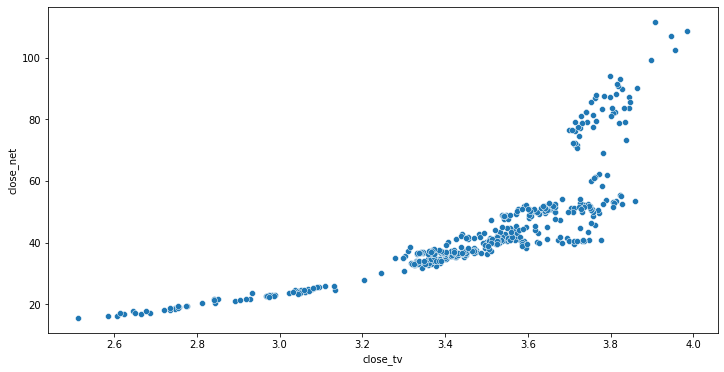

In [41]:
sns.scatterplot(x = np.log(df.close_tv), y = df.close_net)

In [42]:
#Linear Regression
#endog:dependent variable
#To figure out which one should be our dependent varibale Y, and which one dependent variable X
#lets consider each of them dependent and independent once 
Y1 = df.close_net
X1 = df.close_tv
X1 = sm.add_constant(X1)
mod1 = sm.OLS(Y1 , X1).fit()
preds1 = mod1.predict(X1)

print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:              close_net   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1209.
Date:                Sun, 02 Jan 2022   Prob (F-statistic):          3.24e-129
Time:                        19:22:29   Log-Likelihood:                -1621.1
No. Observations:                 449   AIC:                             3246.
Df Residuals:                     447   BIC:                             3254.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5445      1.811     -9.686      0.0

In [43]:
#Linear Regression
#endog:dependent variable
#To figure out which one should be our dependent varibale Y, and which one dependent variable X
#lets consider each of them dependent and independent once 
Y2 = df.close_tv
X2 = df.close_net
X2 = sm.add_constant(X2)

mod2 = sm.OLS(Y2 , X2).fit()
preds2 = mod2.predict(X2)

print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:               close_tv   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1209.
Date:                Sun, 02 Jan 2022   Prob (F-statistic):          3.24e-129
Time:                        19:22:29   Log-Likelihood:                -1275.6
No. Observations:                 449   AIC:                             2555.
Df Residuals:                     447   BIC:                             2563.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9057      0.535     29.747      0.0

In [44]:
standard_error_of_intercept_mod1 = 1.811 #from regression above
standard_error_of_intercept_mod2 = 0.535 #from regression above

#We compute errors for both the model fits
residuals2 = Y2 - preds2
residuals1 = Y1 - preds1

table3 = PrettyTable()
table3.title = 'Summary Table-3 of Parameters'
table3.field_names = ['Parameter', 'Value']
table3.add_row(['Standard Error Of Intercept Model1-->', standard_error_of_intercept_mod1])
table3.add_row(['Standard Error Of Intercept Model2-->', standard_error_of_intercept_mod2])
table3.add_row(['Error Ratio Of Model1--------------->', standard_error_of_intercept_mod1/residuals1.std()])
table3.add_row(['Error Ratio Of Model2--------------->', standard_error_of_intercept_mod2/residuals2.std()])
print(table3)

#Model 2 error ratio is better suggesting TV18 as Y and Network 18 as X
#But from the scatter plot model1 looked better, anyway we'll check with both

+-------------------------------------------------------------+
|                Summary Table-3 of Parameters                |
+---------------------------------------+---------------------+
|               Parameter               |        Value        |
+---------------------------------------+---------------------+
| Standard Error Of Intercept Model1--> |        1.811        |
| Standard Error Of Intercept Model2--> |        0.535        |
| Error Ratio Of Model1---------------> | 0.20215242111259857 |
| Error Ratio Of Model2---------------> | 0.12891712774139402 |
+---------------------------------------+---------------------+


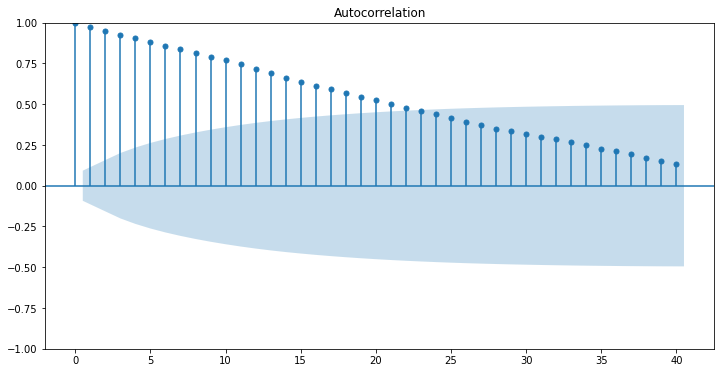

In [45]:
from statsmodels.graphics import tsaplots
#Linear regression assumption fail-1: errors are autocorrelated
#Blue region gives margin of error(95% confidence interval)(if data goes beyond this:non stationary)
#looks non-stationary from the ACF plot,:
fig1 = tsaplots.plot_acf(residuals2, lags=40 )

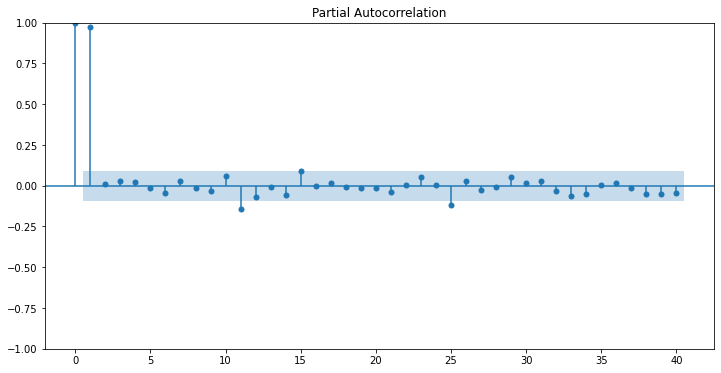

In [46]:
#The partial autocorrelation at lag k is the correlation that results after removing 
#the effect of any correlations due to the terms at shorter lags.

fig2 = tsaplots.plot_pacf(residuals2, lags=40, method='ywm' )

In [48]:
from statsmodels.tsa.stattools import adfuller
result2 = adfuller(residuals2)

In [49]:
#We apply ADF test on our residuals series to check if its stationary
#Null hypothesis: time series is non-stationary
#we fail to reject the null hypothesis and in turn that the time series(error terms) are non-stationary.
print('ADF Statistic:',result2[0])
print('p-value:', result2[1])
for key, value in result2[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.0649626619789454
p-value: 0.25883459107622464
	1%: -3.445
	5%: -2.868
	10%: -2.570


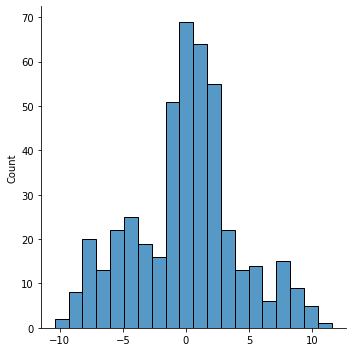

In [50]:
#error doesn't look normally distributed:Linear Regression assumption fail
sns.displot(residuals2)

In [47]:
#Durbin watson test for autocorrelation
#Assumptions are:
#The errors are normally distributed with a mean value of 0.
#The errors are stationary. 

#Both the assumptions have failed, so the result of durbin watson isn't reliable
#Null Hypothesis Ho : First order autocorrelation does not exist
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residuals2)

0.045326753129461876

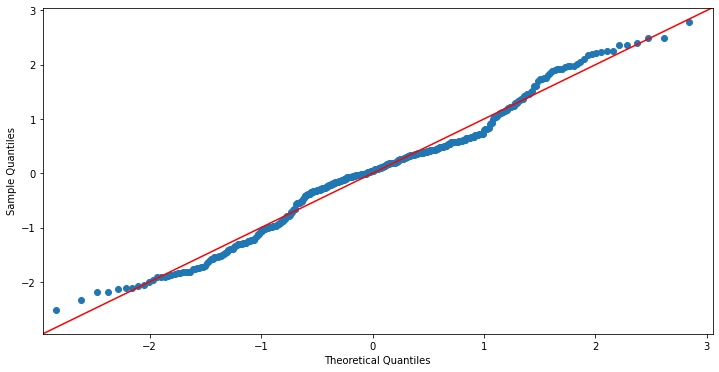

In [51]:
#Looked Normal in distribution plot but doesn't follow a normal - distribution
plot21 = sm.qqplot(residuals2,line='45',fit=True, dist=stats.norm)

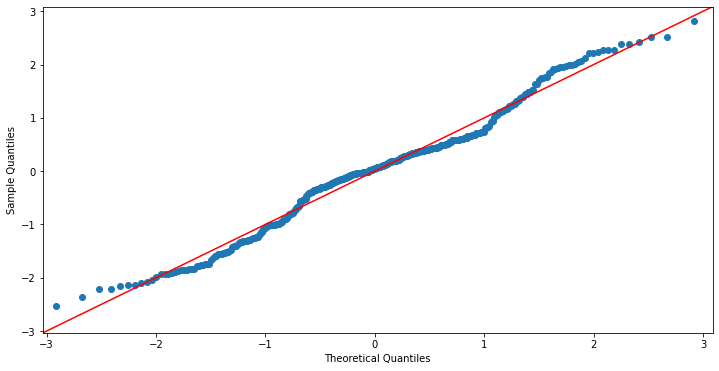

In [52]:
#Looked Normal in distribution plot but doesn't follow a t - distribution
plot22 = sm.qqplot(residuals2,line='45',fit=True, dist=stats.t)

Text(0, 0.5, 'Residuals')

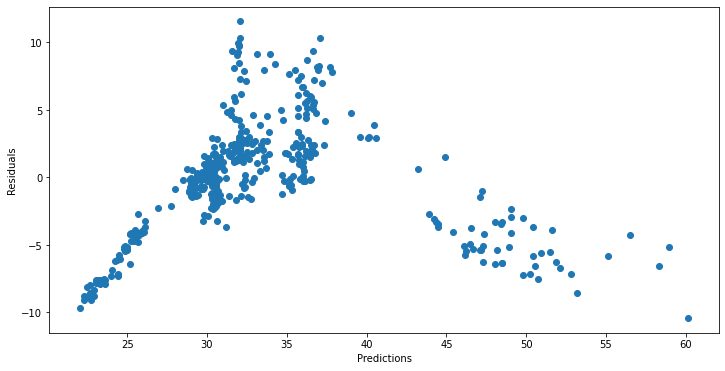

In [53]:
#Linear regression assumption fail
#Looks like hetersckedastic #non-constant variance in the error terms
plt.scatter(preds2, residuals2)
plt.xlabel('Predictions')
plt.ylabel('Residuals')

In [54]:
#The idea was to trade the residual(e) in case of below eqn by taking long short position in X and Y;
#Long the pair: Buy Y and Sell slope*X when residuals hits 2 stdv below the mean(95% probability that reiduals will fall)
#Short the pair: Sell Y and Buy slope*X when residuals hits 2 stdv above the mean
# Y = slope*X + C + e

In [55]:
residuals_lst = [] 
for val in residuals2:
    residuals_lst.append(stats.percentileofscore(residuals2, val, kind='mean'))

#stored percentile of evey time series value of residuals2, 
#they are supposed to return back to mean
df['density_residuals'] = residuals_lst

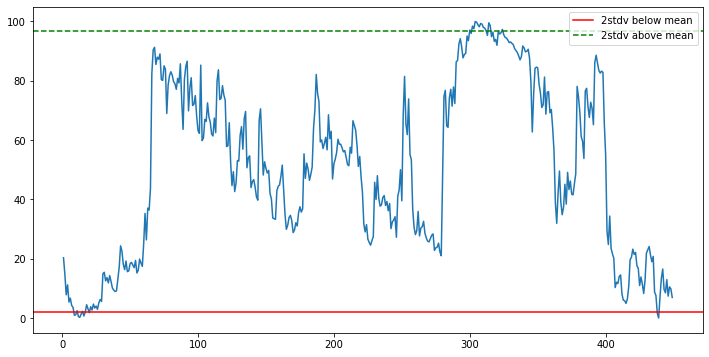

In [56]:
#red line would have denoted trading opportunity if residuals were stationary
plt.plot(df.density_residuals)
plt.axhline(y = stats.percentileofscore(residuals2, residuals2.mean()-2*residuals2.std(), kind='mean'), color='r', linestyle='-', label='2stdv below mean')
plt.axhline(y = stats.percentileofscore(residuals2, residuals2.mean()+2*residuals2.std(), kind='mean'), color='g', linestyle='--', label='2stdv above mean')

plt.legend()

In [57]:
#Similarly for the model-1
#here p value is worst, we fail to reject the null
result1 = adfuller(residuals1)
print('ADF Statistic:',result1[0])
print('p-value:', result1[1])
for key, value in result1[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.1411890022359148
p-value: 0.6983699581182965
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [58]:
#we fail to reject the null hypothesis and in turn that the time series(error terms) are non-stationary.

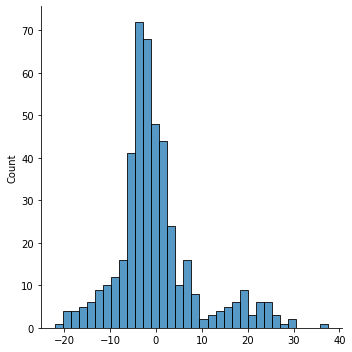

In [59]:
#error looks slightly like normal distribution
sns.displot(residuals1)

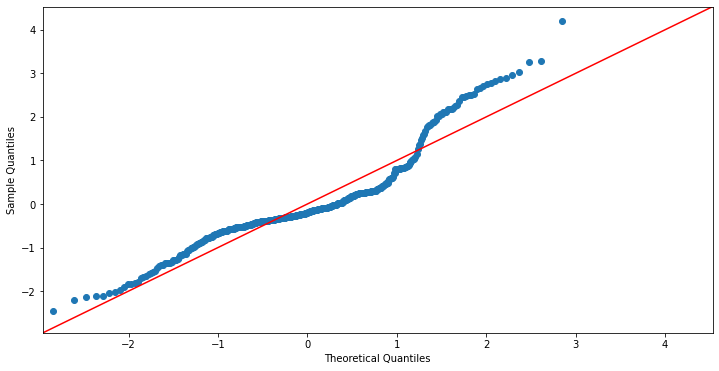

In [60]:
#Looked Normal in distribution plot but doesn't follow a normal - distribution
plot1 = sm.qqplot(residuals1,line='45',fit=True, dist=stats.norm)

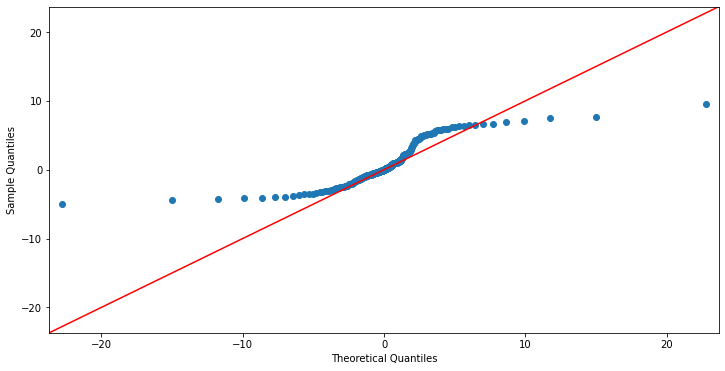

In [61]:
#Looked Normal in distribution plot but doesn't follow a t - distribution
plot2 = sm.qqplot(residuals1,line='45',fit=True, dist=stats.t)

Text(0, 0.5, 'Residuals')

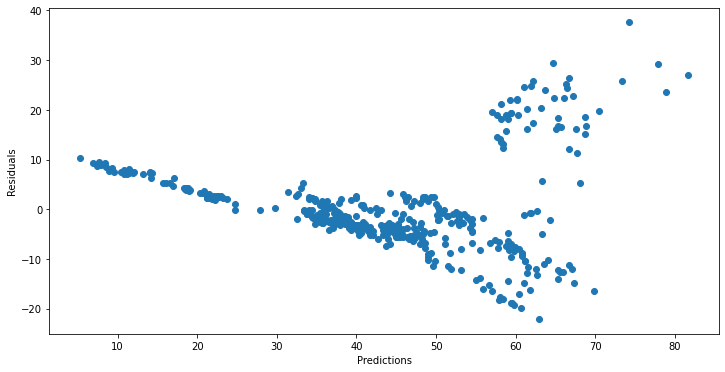

In [62]:
#Linear regression assumption fail- funnel shape
#Looks like hetersckedastic #non-constant variance in the error terms
plt.scatter(preds1, residuals1)
plt.xlabel('Predictions')
plt.ylabel('Residuals')

In [64]:
#Durbin watson test for autocorrelation
#Assumptions are:
#The errors are normally distributed with a mean value of 0.
#The errors are stationary. 

#Both the assumptions have failed, so the result of durbin watson isn't reliable
#Null Hypothesis Ho : First order autocorrelation does not exist
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residuals1)

0.03745294696684485